## Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1234)
tf.random.set_seed(1234)

2024-05-09 10:59:36.439949: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 10:59:36.493434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load model for post processing

In [2]:
channel_180 = tf.keras.models.load_model('Re_180/Saved_model/')
channel_395 = tf.keras.models.load_model('Re_395/Saved_model/')
channel_590 = tf.keras.models.load_model('Re_590/Saved_model/')

#Re_180
X_test, Y_test = np.meshgrid(tf.linspace(start=0, stop=1, num=3)
                             ,tf.linspace(start=31/180, stop=1, num=200))
        
test_data = np.hstack((X_test.flatten()[:, None], Y_test.flatten()[:, None]))
x_test = tf.cast(test_data[:, 0:1],tf.float32)
y_test = tf.cast(test_data[:, 1:2],tf.float32)

with tf.GradientTape(persistent=True) as tape:
    tape.watch([x_test, y_test])
    channel_180_model = channel_180([x_test,y_test])
nu_t = 0.09 * tf.square(channel_180_model[2]) / (channel_180_model[3])
du = tf.cast(tape.gradient(channel_180_model[0], y_test), tf.float32)
shear_stress = nu_t * du
PINN_180 = np.hstack((y_test,np.array(channel_180_model).reshape(4,-1).T,np.array(shear_stress)))

#Re_395
X_test, Y_test = np.meshgrid(tf.linspace(start=0, stop=1, num=3)
                             ,tf.linspace(start=50/395, stop=1, num=200))
        
test_data = np.hstack((X_test.flatten()[:, None], Y_test.flatten()[:, None]))
x_test = tf.cast(test_data[:, 0:1],tf.float32)
y_test = tf.cast(test_data[:, 1:2],tf.float32)

with tf.GradientTape(persistent=True) as tape:
    tape.watch([x_test, y_test])
    channel_395_model = channel_395([x_test,y_test])
nu_t = 0.09 * tf.square(channel_395_model[2]) / (channel_395_model[3])
du = tf.cast(tape.gradient(channel_395_model[0], y_test), tf.float32)
shear_stress = nu_t * du
PINN_395 = np.hstack((y_test,np.array(channel_395_model).reshape(4,-1).T,np.array(shear_stress)))

#Re_590
X_test, Y_test = np.meshgrid(tf.linspace(start=0, stop=1, num=3)
                             ,tf.linspace(start=50/590, stop=1, num=200))
        
test_data = np.hstack((X_test.flatten()[:, None], Y_test.flatten()[:, None]))
x_test = tf.cast(test_data[:, 0:1],tf.float32)
y_test = tf.cast(test_data[:, 1:2],tf.float32)

with tf.GradientTape(persistent=True) as tape:
    tape.watch([x_test, y_test])
    channel_590_model = channel_590([x_test,y_test])
nu_t = 0.09 * tf.square(channel_590_model[2]) / (channel_590_model[3])
du = tf.cast(tape.gradient(channel_590_model[0], y_test), tf.float32)
shear_stress = nu_t * du
PINN_590 = np.hstack((y_test,np.array(channel_590_model).reshape(4,-1).T,np.array(shear_stress)))

2024-05-09 10:59:39.267437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1036 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c3:00.0, compute capability: 8.6


2024-05-09 10:59:41.962186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Load data for comparison

In [3]:
#Re_180
rans_180 = pd.read_csv('RANS_data/180_RANS.csv')
dns_180 = pd.read_csv('DNS_data/180_DNS.csv',delim_whitespace=True)

#Re_395
rans_395 = pd.read_csv('RANS_data/395_RANS.csv')
dns_395 = pd.read_csv('DNS_data/395_DNS.csv',delim_whitespace=True)

#Re_590
rans_590 = pd.read_csv('RANS_data/590_RANS.csv')
dns_590 = pd.read_csv('DNS_data/590_DNS.csv',delim_whitespace=True)

/tmp/ipykernel_3757243/1401432494.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dns_180 = pd.read_csv('DNS_data/180_DNS.csv',delim_whitespace=True)
/tmp/ipykernel_3757243/1401432494.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dns_395 = pd.read_csv('DNS_data/395_DNS.csv',delim_whitespace=True)
/tmp/ipykernel_3757243/1401432494.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dns_590 = pd.read_csv('DNS_data/590_DNS.csv',delim_whitespace=True)


## Function for generating profile plots

In [9]:
def profile_plots(DNS, RANS, PINN, Re):

    y_dns,u_dns,k_dns,eps_dns,stress_dns = DNS['y'], DNS['u'], DNS['k'], DNS['eps'], DNS['stress']
    y_rans, u_rans, k_rans, eps_rans, stress_rans = RANS['y'], RANS['u'], RANS['k'], RANS['eps'], -1*RANS['stress']
    y, u, v, k, eps, shear_stress = PINN[::3,0],PINN[:,1],PINN[:,2],PINN[:,3],PINN[:,4],PINN[:,5]

    fig, ax = plt.subplots(4, 1, figsize=(3,12))
    ax[0].plot(u_dns,y_dns ,':', label = 'DNS')
    ax[0].set_title(r'Mean Velocity ($\bar U$)', fontsize = 12)
    ax[0].set_xlabel(r'$\bar U$')
    ax[0].set_ylabel(r'$y$')


    ax[1].plot( k_dns,y_dns,':')
    ax[1].set_title(r'Turbulent Kinetic Energy ($k$)', fontsize = 12)
    ax[1].set_ylabel(r'$y$')
    ax[1].set_xlabel(r'$k$')

    ax[2].plot( eps_dns,y_dns,':')
    ax[2].set_title(r'Rate of Dissipation of TKE ($\epsilon$)', fontsize = 12)
    ax[2].set_ylabel(r'$y$')
    ax[2].set_xlabel(r'$\epsilon$')

    ax[3].plot( stress_dns,y_dns,':')
    ax[3].set_title(r'Turbulent Shear Stress ($\tau_t$)', fontsize = 12)
    ax[3].set_ylabel(r'$y$')
    ax[3].set_xlabel(r'$\tau_t$')

    ax[0].plot(u_rans,y_rans ,':r', label = 'RANS-CFD')
    ax[1].plot(k_rans,y_rans,':r')
    ax[2].plot(eps_rans,y_rans,':r')
    ax[3].plot(stress_rans,y_rans,':r')
    
    ax[0].plot(u[1::3],y, 'C2',label=f'PINN at mid-channel')
    ax[0].plot(u[2::3],y, 'C1--',dashes=[3, 5],label=f'PINN at outlet')
    ax[0].grid(which='both',alpha=0.4)
    ax[0].minorticks_on()


    ax[1].plot(k[1::3],y, 'C2')
    ax[1].plot(k[2::3],y, 'C1--',dashes=[3, 5])
    ax[1].grid(which='both',alpha=0.4)
    ax[1].minorticks_on()

    ax[2].plot(eps[1::3],y,'C2')
    ax[2].plot(eps[2::3],y, 'C1--',dashes=[3, 5])
    ax[2].grid(which='both',alpha=0.4)
    ax[2].minorticks_on()


    ax[3].plot(shear_stress[1::3],y, 'C2')
    ax[3].plot(shear_stress[2::3],y,'C1--',dashes=[3, 5])
    ax[3].grid(which='both',alpha=0.4)
    ax[3].minorticks_on()
    
    ax[0].set_xlim(0,22)
    ax[1].set_xlim(0,5)
    ax[2].set_xlim(0,30)
    ax[3].set_xlim(0,1.10)

    fig.legend(loc='center left', bbox_to_anchor=(1, 0.9))
    fig.suptitle(fr"$Re_\tau$ = {Re}", fontsize=16)
    fig.tight_layout()

    plt.savefig(f'Plots/Channel_{Re}.png',dpi=300,bbox_inches='tight')

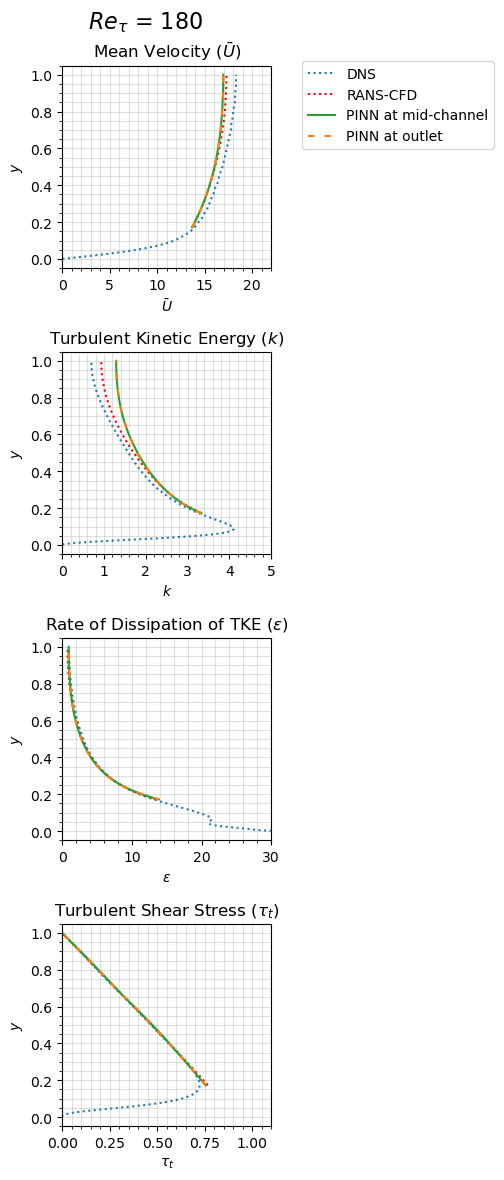

In [10]:
profile_plots(dns_180,rans_180,PINN_180,180)


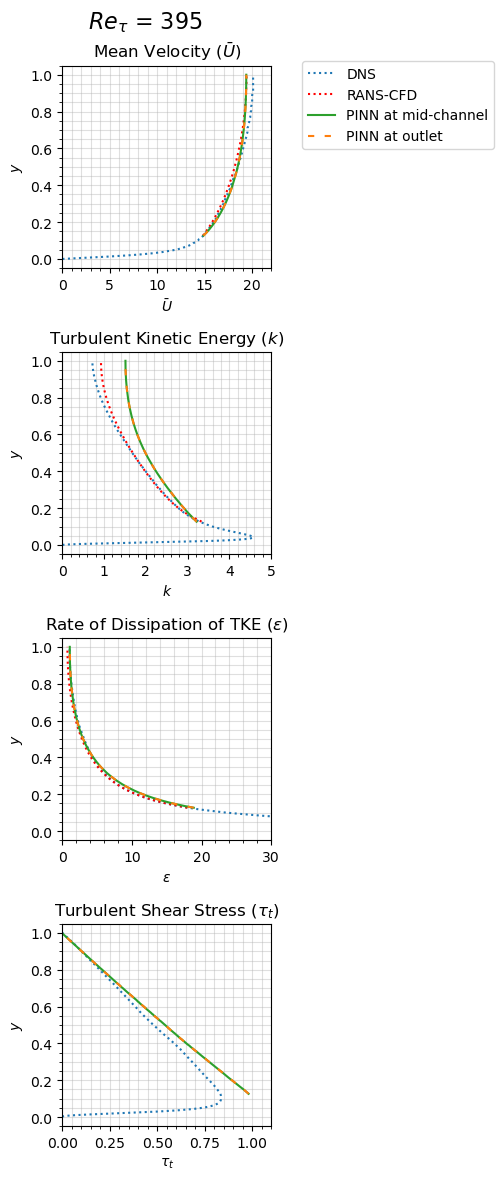

In [11]:
profile_plots(dns_395,rans_395,PINN_395,395)

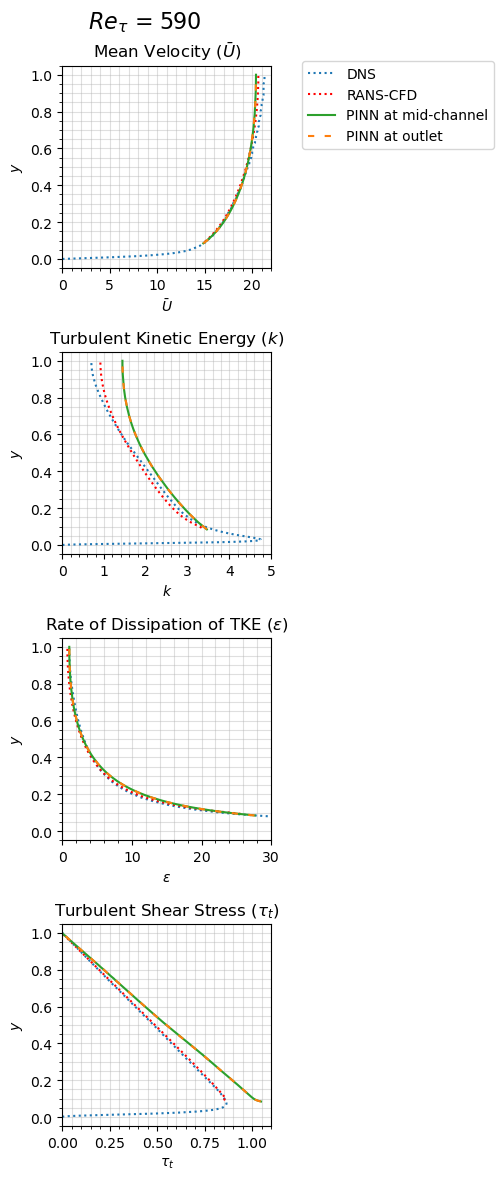

In [12]:
profile_plots(dns_590,rans_590,PINN_590,590)
